In [1]:
import keras
from keras.models import load_model
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import BatchNormalization, Dropout
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
model = load_model("./cnn_model/077-0.9942.h5")
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)      

In [2]:
scaler = StandardScaler()
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

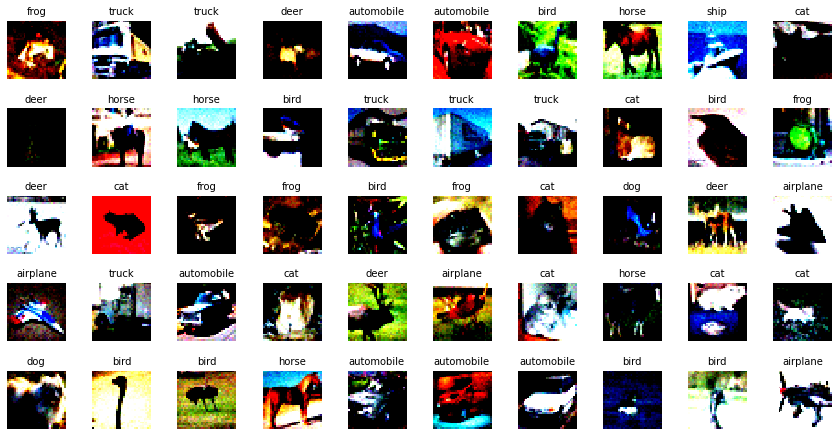

In [3]:
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], 32*32*3))
X_test = scaler.transform(X_test.reshape(X_test.shape[0], 32*32*3))

# Implementation uniform noise.
noise_param = 0.1
noise_X_train = X_train + noise_param * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
noise_X_test = X_test + noise_param * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
noise_X_train = np.clip(noise_X_train, 0, 1)
noise_X_test = np.clip(noise_X_test, 0, 1)
noise_X_train = noise_X_train.reshape(noise_X_train.shape[0], 32, 32, 3)
noise_X_test = noise_X_test.reshape(noise_X_test.shape[0], 32, 32, 3)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(noise_X_train[index], interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index][0]], fontsize=10)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [4]:
# X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], 32*32*3))
# X_test = scaler.transform(X_test.reshape(X_test.shape[0], 32*32*3))
# X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
# X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [5]:
model_clone = keras.models.clone_model(model)
model_clone.set_weights(model.get_weights())

model = keras.models.Sequential(model_clone.layers[:-6])
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5, name="dropout_4"))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)      

In [6]:
for layer in model.layers[:-3]:
    layer.trainable = False

model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
#result1 = model.fit(X_train, y_train, epochs=3, batch_size=1024, validation_data=[X_test, y_test])
result1 = model.fit(noise_X_train, y_train, epochs=3, batch_size=1024, validation_data=[noise_X_test, y_test])

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 9s 175us/step - loss: 1.1071 - accuracy: 0.6314 - val_loss: 1.1494 - val_accuracy: 0.5989
Epoch 2/3
50000/50000 [==============================] - 5s 92us/step - loss: 0.7834 - accuracy: 0.7294 - val_loss: 1.1106 - val_accuracy: 0.6153
Epoch 3/3
50000/50000 [==============================] - 5s 93us/step - loss: 0.7275 - accuracy: 0.7442 - val_loss: 1.0958 - val_accuracy: 0.6179


In [7]:
%%time
for layer in model.layers[:-3]:
    layer.trainable = True

#optimizer = keras.optimizers.SGD(lr=1e-4) # default lr = 1e-2
optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999) # default lr = 0.001
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
#result2 = model.fit(X_train, y_train, epochs=5, batch_size=1024, validation_data=[X_test, y_test])
result2 = model.fit(noise_X_train, y_train, epochs=5, batch_size=1024, validation_data=[noise_X_test, y_test])

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 19s 381us/step - loss: 0.6717 - accuracy: 0.7660 - val_loss: 0.9072 - val_accuracy: 0.6864
Epoch 2/5
50000/50000 [==============================] - 15s 301us/step - loss: 0.6346 - accuracy: 0.7784 - val_loss: 0.7959 - val_accuracy: 0.7266
Epoch 3/5
50000/50000 [==============================] - 15s 302us/step - loss: 0.6099 - accuracy: 0.7863 - val_loss: 0.7390 - val_accuracy: 0.7454
Epoch 4/5
50000/50000 [==============================] - 15s 303us/step - loss: 0.5935 - accuracy: 0.7934 - val_loss: 0.7073 - val_accuracy: 0.7575
Epoch 5/5
50000/50000 [==============================] - 15s 306us/step - loss: 0.5716 - accuracy: 0.8017 - val_loss: 0.6881 - val_accuracy: 0.7658
Wall time: 1min 21s


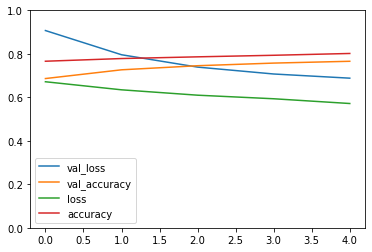

In [8]:
pd.DataFrame(result2.history).plot()
plt.gca().set_ylim(0,1)
plt.show()

In [10]:
model.evaluate(noise_X_test, y_test)

10000/10000 [==============================] - 2s 183us/step


[0.6881365125656128, 0.7657999992370605]